# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Описание данных:**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Откройте и изучите файл

**Подключим необходимые библиотеки и настройки:**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
import time
#from sklearn.metrics import accuracy_score

**Загрузим датафрейм:**

In [2]:
try:
    data = pd.read_csv('users_behavior.csv')
except:
    data = pd.read_csv('users_behavior.csv')

**Создадим и применим функцию функцию, которая будет на вход принимать датафрейм, а на выходе будет выводить все необходимые характеристики поочередно применяя методы:**

In [3]:
def data_info(dataframe):
    print("Характеристики датафрейма:")
    print("-"*100)
    print('Выведем общую информацию по датафрейму:')
    print(data.info())
    print("-"*100)
    print('Выведем первые 10 строк')
    print(data.head(10))
    print("-"*100)
    print('Выведем последние 10 строк')
    print(data.tail(10))
    print("-"*100)
    print('Посмотрим пропуски')
    print(data.isnull().sum().sort_values(ascending=False))
    print("-"*100)
    print('Посмотрим на описание датафрейма')
    print(data.describe())
    print("-"*100)
    print('Количество дубликатов:')
    print(data.duplicated().sum())

In [4]:
data_info(data)

Характеристики датафрейма:
----------------------------------------------------------------------------------------------------
Выведем общую информацию по датафрейму:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None
----------------------------------------------------------------------------------------------------
Выведем первые 10 строк
   calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0
3  106.0   745.53      81.0   8437.39         1
4   66.0   418.74       1.0  14

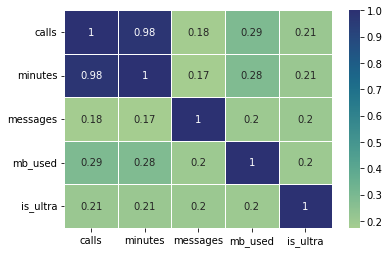

In [5]:
sns.heatmap(data.corr(),annot=True, linewidth=.5, cmap='crest');

**Выводы:**

- В датафрейме 5 столбцов и 3214 строк.
- Столбцы:
    - сalls — количество звонков,
    - minutes — суммарная длительность звонков в минутах,
    - messages — количество sms-сообщений,
    - mb_used — израсходованный интернет-трафик в Мб,
    содержат числовые признаки.
- Столбец is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0) - содержит категориальные признаки.
- Пропусков и дубликатов нет.
- Высокая степень корреляции между признаками calls и minutes может негативно повлиять на качество модели, если между ними есть зависимость. Посмотрим зависимы ли признаки между собой, обучив модель по полным данным, без стобца calls и без столбца minutes.

**Посмотрим на целевой признак - столбец is_ultra:**

In [6]:
data['is_ultra'].value_counts(normalize=True).round(2)

0    0.69
1    0.31
Name: is_ultra, dtype: float64

Если рекомендовать тариф «Ультра», в 69% случаев мы окажемся правы.

## Разбейте данные на выборки

Посколько отдельной тестовой выборки мы не имеем, будем разбивать датасет на 3 части в соотношении 3:1:1 (60% обучающая выборка, 20% валидационная и 20% тестовая).

Извлечем признаки:

In [7]:
features = data.drop(['is_ultra'], axis=1)

Извлечем целевой признак:

In [8]:
target = data['is_ultra']

Отделим обучающую выборку:

In [9]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state=12345, stratify=target)

Разделим оставшиеся данные пополам для тестовой валидационной и тестовой выборки:

In [10]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345, stratify=target_valid)

Проверим разделение:

In [11]:
(
print('Количество строк и столбцов в обучающей выборке:',features_train.shape, 
      ', что составляет', round(len(features_train)/len(data)*100,), '% от данных.')
)
(
print('Количество строк и столбцов в валидационной выборке:',features_valid.shape,
      ', что составляет', round(len(features_valid)/len(data)*100,), '% от данных.')
)
(
print('Количество строк и столбцов в тестовой выборке:',features_test.shape,
      ', что составляет', round(len(features_test)/len(data)*100,), '% от данных.')
)

Количество строк и столбцов в обучающей выборке: (1928, 4) , что составляет 60 % от данных.
Количество строк и столбцов в валидационной выборке: (643, 4) , что составляет 20 % от данных.
Количество строк и столбцов в тестовой выборке: (643, 4) , что составляет 20 % от данных.


Для проверки влияния на качество модели корреляции calls и minutes, сделаем набор выборок без них:

In [12]:
features_train_without_calls = features_train.drop('calls', axis=1)
features_valid_without_calls = features_valid.drop('calls', axis=1)

features_train_without_minutes = features_train.drop('minutes', axis=1)
features_valid_without_minutes = features_valid.drop('minutes', axis=1)

Запишем выборки в словари:

In [13]:
train_sample = {
    'sample': features_train,
    'sample_without_calls': features_train_without_calls,
    'sample_without_minutes': features_train_without_minutes,
}

valid_sample = {
    'sample': features_valid,
    'sample_without_calls': features_valid_without_calls,
    'sample_without_minutes': features_valid_without_minutes,
}

**Вывод:**

Датасет поделен, приступим к исследованию моделей.

## Исследуйте модели

Выберем для исследования следующие классификаторы:
- DecisionTreeClassifier (Дерево решений)
- RandomForestClassifier (Случайный лес)
- LogisticRegression (Логистическая регрессия)


Посмотрим на эти классификаторы с разными гиперпараметрами и выберем наилучшие варианты для каждого классификатора. 
Для подбора гиперпараметров будем пользоваться GridSearchCV. Он находит наилучшие гиперпараметры путем перебора.

**DecisionTreeClassifier (Дерево решений)**

В качестве основных гиперпараметров для DecisionTreeClassifier возьмем:
- max_depth - определяет максимальную глубину дерева.
- min_samples_split - определяет минимальное число объектов в узле дерева, достаточное для дальнейшего разделения.
- min_samples_leaf - определяет минимальное число объектов в листьях дерева.

Создадим функцию, которая возвращает наилучшие гиперпараметры для DecisionTreeClassifier с помощью GridSearchCV
- features - признаки
- target - целевая переменная

In [14]:
def get_dt_params(features, target):
    model = DecisionTreeClassifier(random_state=12345)
    
    max_depth = range(1,10)
    min_samples_split = range(2,20)
    min_samples_leaf = range(1,20)
    
    params = {'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf}
    
    dt_search = GridSearchCV(model, params, cv=5)
    dt_search.fit(features, target)
    return dt_search.best_params_

Создадим функцию, которая возвращает accuracy и обученную модель DecisionTreeClassifier
- params - гиперпараметры
- features - признаки
- target - целевая переменна

In [15]:
def get_dt_score(params, features, target):
    model = DecisionTreeClassifier(random_state=12345, **params)
    model.fit(features, target)
    score = model.score(features, target)
    return score, model

In [16]:
start = time.time() # старт таймера

dt_result = dict()
for name, data in train_sample.items():
    best_params = get_dt_params(data, target_train)
    score, model = get_dt_score(best_params, data, target_train)
    
    dt_result[name] = (model, score)
    
    print(name, score)
    print(best_params, '\n')

end = time.time() - start # стоп таймера
print('Время работы модели:', end)

sample 0.8174273858921162
{'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 18} 

sample_without_calls 0.8257261410788381
{'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 18} 

sample_without_minutes 0.8335062240663901
{'max_depth': 8, 'min_samples_leaf': 7, 'min_samples_split': 15} 

Время работы модели: 288.91184663772583


Наличие или отсутствие столбцов call и minutes кардинально не влияет на качество модели . Оптимальные гиперпараметры для каждой из выборок - различны.

**RandomForestClassifier (Случайный лес)**

В качестве основных гиперпараметров для RandomForestClassifier возьмем:

- n_estimators - определяет количество деревьев в случайном лесу
- max_depth - определяет максимальную глубину дерева.
- min_samples_leaf - определяет минимальное число объектов в листьях дерева.
- min_samples_split -определяет минимальное число объектов в узле дерева, достаточное для дальнейшего разделения.
- max_features - определяет число признаков для выбора разделения.


Создадим функцию, которая возвращает наилучшие гиперпараметры для RandomForestClassifier с помощью GridSearchCV
- features - признаки
- target - целевая переменная

In [17]:
def get_rf_params(features, target):
    model = RandomForestClassifier(random_state=12345)
    
    n_estimators = range (10, 51, 10)
    max_depth = range (1,13, 2)
    min_samples_leaf = range (1, 4)
    min_samples_split = range (2, 8, 2)
    max_features = ['log2', 'sqrt']
      
    params = {'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf,
            'max_features': max_features}
    
    rf_search = GridSearchCV(model, params, cv=5)
    rf_search.fit(features, target)
    return rf_search.best_params_

Создадим функцию, которая возвращает accuracy и обученную модель RandomForestClassifier
- params - гиперпараметры
- features - признаки
- target - целевая переменная

In [18]:
def get_rf_score(params, features, target):
    model = RandomForestClassifier(random_state=12345, **params)
    model.fit(features, target)
    score = model.score(features, target)
    return score, model

In [19]:
start = time.time() # старт таймера

rf_result = dict()
for name, data in train_sample.items():
    best_params = get_rf_params(data, target_train)
    score, model = get_rf_score(best_params, data, target_train)
    
    rf_result[name] = (model, score)
    
    print(name, score)
    print(best_params, '\n') 

end = time.time() - start # стоп таймера
print('Время работы модели:', end)

sample 0.8599585062240664
{'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 10} 

sample_without_calls 0.8625518672199171
{'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 30} 

sample_without_minutes 0.8620331950207469
{'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 20} 

Время работы модели: 610.9635608196259


Также, как и в дереве решений, наличие или отсутствие столбцов call и minutes в случайном лесу кардинально не влияет на качество модели . Оптимальные гиперпараметры для каждой из выборок одинаковы в max_features и min_samples_split.

**LogisticRegression (Логистическая регрессия)**

Для LogisticRegression используем cross_val_score для перекрестной проверки.

In [20]:
lr_result = dict()
for name, data in train_sample.items():
    model = LogisticRegression(random_state=12345)
    score = cross_val_score(model, data, target_train, scoring = 'accuracy').mean()
    model.fit(data, target_train)
    
    lr_result[name] = (model, score)
    
    print(name, score, '\n') 

sample 0.7365022542224614 

sample_without_calls 0.7240643294529304 

sample_without_minutes 0.7510369423322791 



Как и в предущих классификаторах наличие или отсутствие столбцов call и minutes кардинально не влияет на качество модели.
Но качество модели сильно хуже.

Посмотрим на сводную таблицу:

In [21]:
research_result = pd.DataFrame([
    {keys:values[1] for keys,values in dt_result.items()},
    {keys:values[1] for keys,values in rf_result.items()}, 
    {keys:values[1] for keys,values in lr_result.items()}, 
    ],
    index = ['DecisionTreeClassifier','RandomForestClassifier', 'LogisticRegression'])

research_result

,sample,sample_without_calls,sample_without_minutes
DecisionTreeClassifier,0.817427,0.825726,0.833506
RandomForestClassifier,0.859959,0.862552,0.862033
LogisticRegression,0.736502,0.724064,0.751037


**Вывод**

Наилучший результат у RandomForestClassifier. Отсутствие столбцов call или minutes кардинально не влияет на качество моделей, поэтому мы можем сделать вывод, что эти признаки не зависимы.

In [22]:
best_model = rf_result['sample'][0]
print('Гиперпараметры наилучшей модели:', best_model)

Гиперпараметры наилучшей модели: RandomForestClassifier(max_depth=9, max_features='log2', min_samples_leaf=2,
                       n_estimators=10, random_state=12345)


**Посмотрим влияние глубины деревьев на качество моделей**

Создадим функцию, которая возвращает список обученых на признаках "Х" и целевой переменной "у" моделей  с глубиной дерева от 1 до max_depth

In [23]:
def model_for_max_depth(classifier, X, y, max_depth):    
    result = []
    for depth in range(1, max_depth):
        model = classifier(random_state=12345, max_depth=depth)
        model.fit(X, y)
        result.append(model)
    return result

In [24]:
start = time.time() # старт таймера

dt_models = model_for_max_depth(DecisionTreeClassifier, features_train, target_train, 50)
rf_models = model_for_max_depth(RandomForestClassifier, features_train, target_train, 50)

dt_train_score = [model.score(features_train, target_train) for model in dt_models]
dt_valid_score = [model.score(features_valid, target_valid) for model in dt_models]

rf_train_score = [model.score(features_train, target_train) for model in rf_models]
rf_valid_score = [model.score(features_valid, target_valid) for model in rf_models]

end = time.time() - start # стоп таймера
print('Время работы модели:', end)

Время работы модели: 23.82042384147644


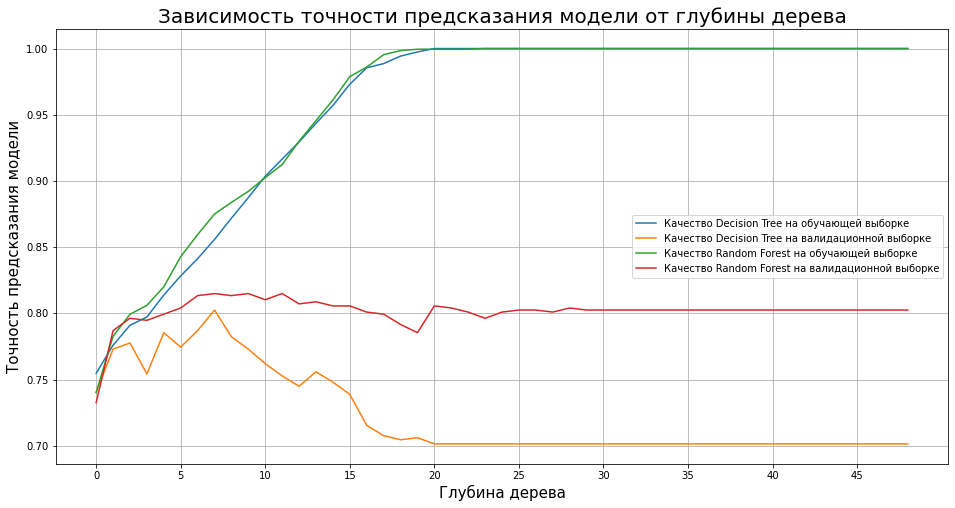

In [25]:
plt.figure(figsize=(16, 8))
plt.plot(dt_train_score)
plt.plot(dt_valid_score)
plt.plot(rf_train_score)
plt.plot(rf_valid_score)
plt.xticks(np.arange(0, 50, step=5)) 
plt.ylabel('Точность предсказания модели', fontsize=15)
plt.xlabel('Глубина дерева', fontsize=15)
plt.title('Зависимость точности предсказания модели от глубины дерева', fontsize=20)
plt.legend([
    'Качество Decision Tree на обучающей выборке', 
    'Качество Decision Tree на валидационной выборке',
    'Качество Random Forest на обучающей выборке', 
    'Качество Random Forest на валидационной выборке',
])
plt.grid();

**Вывод:**

- У Decision Tree точность на валидационной выборке растет до глубины 7. Далее точность резко снижается в связи с переобучением.
- У Random Forest точность на валидационной выборке растет до глубины 5-12. Далее мы наблюдаем снижение точности на валидационной выборке. Скорее всего качество модели тоже снижается.
- После того как точность предсказания модели у Decision Tree и Random Forest на обучающей выборке достигает единицы, разделение решающих деревьев прекращается и модель перестает изменятся.
- Точность Random Forest выше чем Decision Tree.

**Посмотрим влияние количества деревьев на качество моделей**

Создадим функцию, которая возвращает список обученых на признаках "Х" и целевой переменной "у" моделей с количеством деревьев в диапазоне от 1 до n_estimators

In [26]:
def model_for_n_estimators(classifier, X, y, n_estimators):
    models = []
    for n_estimators in range(1, n_estimators):
        model = classifier(random_state=12345, n_estimators=n_estimators)
        model.fit(X, y)
        models.append(model)
    return models

In [27]:
start = time.time() # старт таймера

nrf_models = model_for_n_estimators(RandomForestClassifier, features_train, target_train, 51)

nrf_train_score = [model.score(features_train, target_train) for model in nrf_models]
nrf_valid_score = [model.score(features_valid, target_valid) for model in nrf_models]

end = time.time() - start # стоп таймера
print('Время работы модели:', end)

Время работы модели: 6.7936131954193115


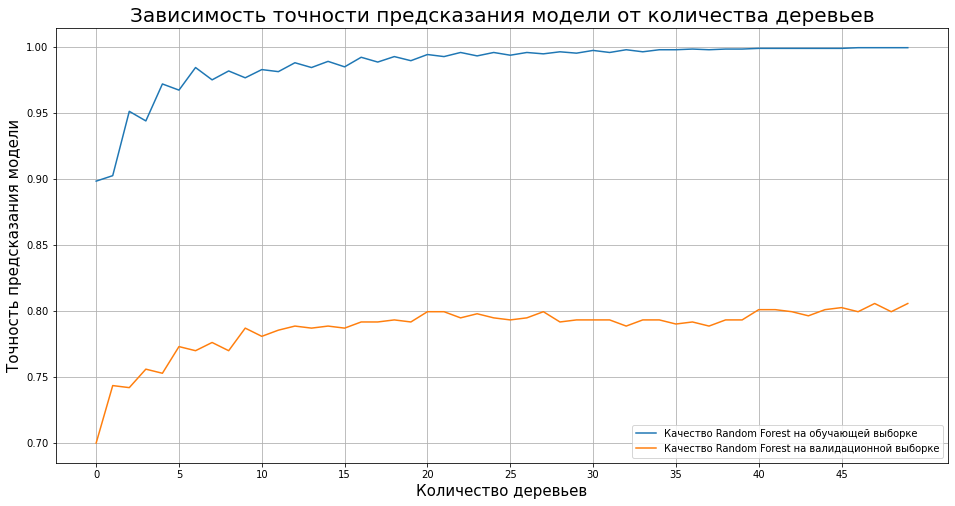

In [28]:
plt.figure(figsize=(16, 8))
plt.plot(nrf_train_score)
plt.plot(nrf_valid_score)
plt.xticks(np.arange(0, 50, step=5)) 
plt.ylabel('Точность предсказания модели', fontsize=15)
plt.xlabel('Количество деревьев', fontsize=15)
plt.title('Зависимость точности предсказания модели от количества деревьев', fontsize=20)
plt.legend([
    'Качество Random Forest на обучающей выборке', 
    'Качество Random Forest на валидационной выборке'
])
plt.grid();

**Вывод:**

- Кривая для обучающей выборки растет с увеличением количества деревьев, а кривая для валидационной выборки может начать падать, если модель начинает переобучаться. 
- Валидационная кривая начинает падать и отстает от кривой для обучающей выборки в районе 10 деревьев. 
- Мы можем сделать вывод, что дальнейшее увеличение количества деревьев приводит к переобучению модели.

## Проверьте модель на тестовой выборке

In [29]:
score = best_model.score(features_test, target_test)
print('Точность предсказания модели на тестовой сборке:', score)

Точность предсказания модели на тестовой сборке: 0.8102643856920684


**Вывод**

По заданию, нам надо было довести долю правильных ответов по крайней мере до 0.75 - с чем мы справились.

## (бонус) Проверьте модели на адекватность

Для проверки модели на адекватность возьмем DummyClassifier. Это классификатор,который делает прогнозы,используя простые правила. Он полезен в качестве простой основы для сравнения с другими (реальными)классификаторами.
Используем стратегию 'most_frequent' - всегда предсказывать наиболее часто встречающуюся метку в обучающем наборе.

In [30]:
dummy_model = DummyClassifier(strategy='most_frequent') 
dummy_model.fit(features_train, target_train)
dummy_score = dummy_model.score(features_test, target_test)
print('Точность предсказания модели на тестовой сборке c DummyClassifier:', dummy_score)
print('Точность предсказания модели на тестовой сборке c Random Forest:', score)

Точность предсказания модели на тестовой сборке c DummyClassifier: 0.6936236391912908
Точность предсказания модели на тестовой сборке c Random Forest: 0.8102643856920684


**Вывод:**

С DummyClassifier точность предсказания модели хуже, чем с Random Forest, Decision Tree и LogisticRegression.

**Обший вывод:**

В этом проекте мы:
- Загрузили необходимые библиотеки и посмотрели данные.
- Обнаружили сильную корреляцию между признаками calls и minutes, и решили проверить влияет ли она на качество модели.
- Разбили датасет на на 3 части в соотношении 3:1:1 (60% обучающая выборка, 20% валидационная и 20% тестовая).
- Для проверки влияния на качество модели корреляции calls и minutes, сделали набор выборок без них.
- Исследовали модели со следующими классификаторами:
    - DecisionTreeClassifier (Дерево решений)
    - RandomForestClassifier (Случайный лес)
    - LogisticRegression (Логистическая регрессия)
- Определили, что наличие или отсутствие столбцов call и minutes кардинально не влияет на качество модели.
- Определили, что из 3-х классификаторов, точность предсказания модели c Random Forest самая высокая.
    - Точность предсказания модели c Random Forest: 0.8599585062240664
    - Точность предсказания модели c Decision Tree: 0.8174273858921162
    - Точность предсказания модели c LogisticRegression: 0.7365022542224614
- Посмотрели влияние глубины деревьев на качество моделей и определили, что после того как точность предсказания модели у Decision Tree и Random Forest на обучающей выборке достигает единицы, разделение решающих деревьев прекращается и модель перестает изменятся.
- Посмотрели влияние количества деревьев на качество моделей и определили, что после десятого дерева модель начинает переобучаться.
- Проверили модель на тестовой выборке и определили, что доля правильных ответов выше, чем миниму по заданию (0.75)
- Проверили модели на адекватность при помощи DummyClassifier